# Starter Notebook - StatsSA

This notebook introduces the Zindi competition **Women in Big Data South Africa - Women-Headed Households in South Africa**. We'll take a quick look at the data, show how to create a model, estimate the score you'll get on Zindi, prepare your submission and get onto the leaderboard. I've also given some hints as to how to get a better score - once you have your first submission in, these might give you some ideas for what to try next.

# Loading the data
Make sure the CSV files provided by Zindi are in the same folder as this notebook. If it's running on Google Colab, you can use the 'files' tab on the left to upload them. We load the training data from Train.csv, and print out the variable descriptions here for easy reference. 

In [3]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

In [4]:
df = pd.read_csv('Train.csv')
df.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


In [5]:
var_desc = pd.read_csv('variable_descriptions.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc

,Column,Description,Unnamed: 2,Unnamed: 3
0,dw_00,Percentage of dwellings of type: House or brick/concrete block structure on a separate stand or yard or on a farm,NaN,NaN
1,dw_01,Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials,NaN,NaN
2,dw_02,Percentage of dwellings of type: Flat or apartment in a block of flats,NaN,NaN
3,dw_03,Percentage of dwellings of type: Cluster house in complex,NaN,NaN
4,dw_04,Percentage of dwellings of type: Townhouse (semi-detached house in a complex),NaN,NaN
5,dw_05,Percentage of dwellings of type: Semi-detached house,NaN,NaN
6,dw_06,Percentage of dwellings of type: House/flat/room in backyard,NaN,NaN
7,dw_07,Percentage of dwellings of type: Informal dwelling (shack,in backyard),NaN
8,dw_08,Percentage of dwellings of type: Informal dwelling (shack,not in backyard,e.g. in an informal/squatter settlement or on a farm)
9,dw_09,Percentage of dwellings of type: Room/flatlet on a property or larger dwelling/servants quarters/granny flat,NaN,NaN


# Quick EDA
Before we dive into modelling, let's take a quick look at the data and see what we have to work with. 

## Looking at the target variable
The purpose of this competition is to predict the percentage of households in a ward that are woman-headed and have an annual household income of <R19,600. To put that in context, that's less than 250USD per month. 

Text(0.5,0,'Percentage of households that are w-headed and have income under R19.6k/month')

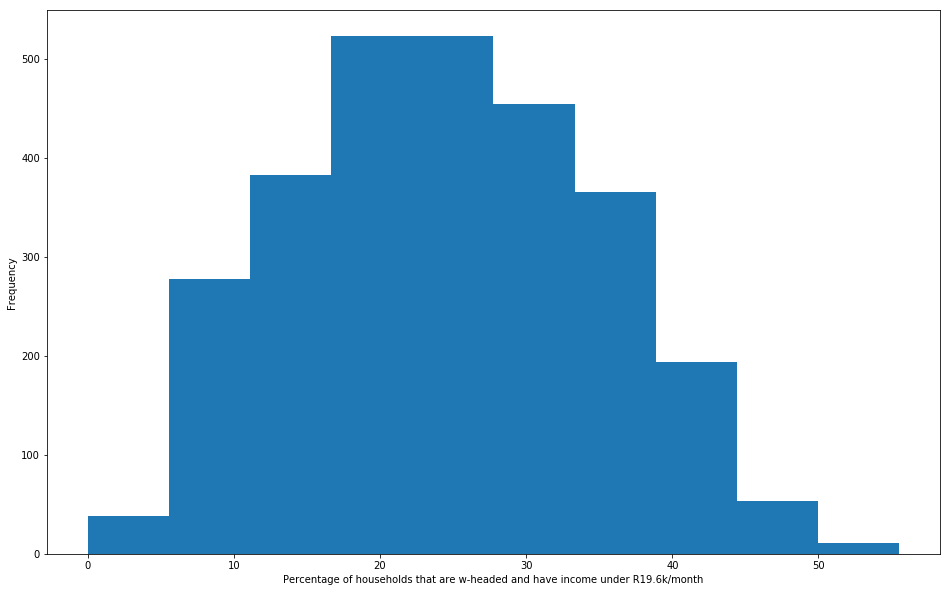

In [6]:
# Plot the distribution
ax = df['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month')

# Looking at a few interesting correlations

In [7]:
# Strong +ve correlations
df.corr()['target'].sort_values(ascending=False).head(10)

target    1.000000
psa_00    0.782472
car_01    0.702831
stv_01    0.664181
lln_01    0.637835
pg_00     0.613346
pw_06     0.470676
dw_01     0.458206
pw_02     0.442441
pw_03     0.440941
Name: target, dtype: float64

In [8]:
# And negative correlations
df.corr()['target'].sort_values().head(10)

pw_00    -0.754536
psa_01   -0.707506
car_00   -0.702831
stv_00   -0.664181
lln_00   -0.637835
pg_03    -0.583908
NL       -0.514398
lan_00   -0.507942
lan_01   -0.438704
dw_04    -0.385533
Name: target, dtype: float64

There are some high correlations here. Let's pick a few and investigate.

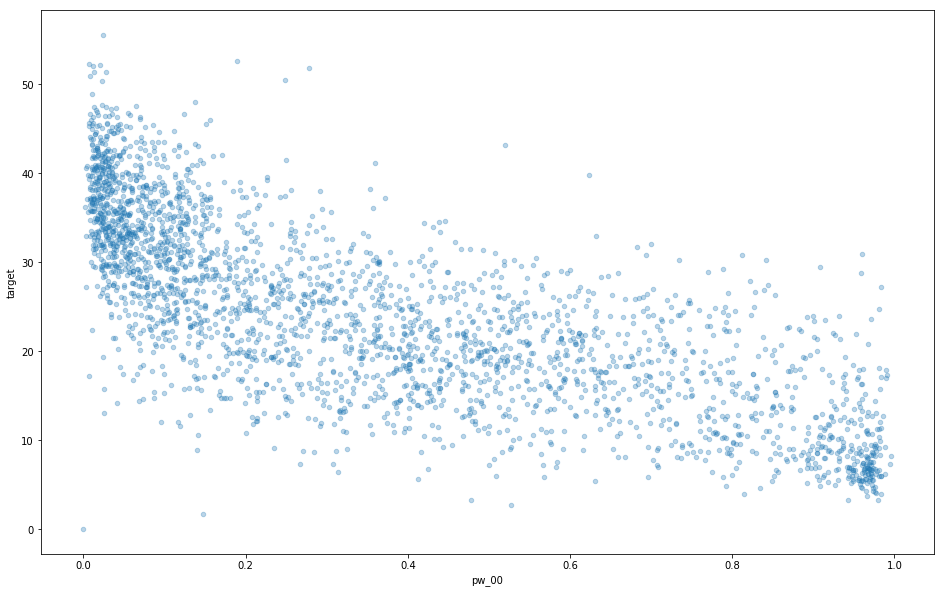

In [9]:
# pw_00: running water in the home. Places where almost everyone has piped water tend to be more affluent.
df.plot(x='pw_00', y='target', kind='scatter', alpha=0.3)

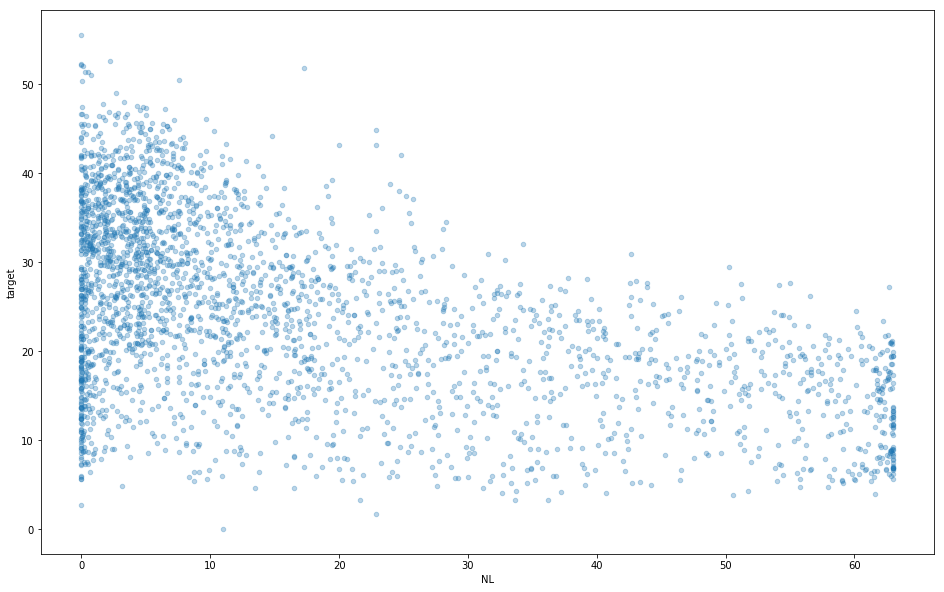

In [38]:
# Nightlights (NL)
df.plot(x='NL', y='target', kind='scatter', alpha=0.3)

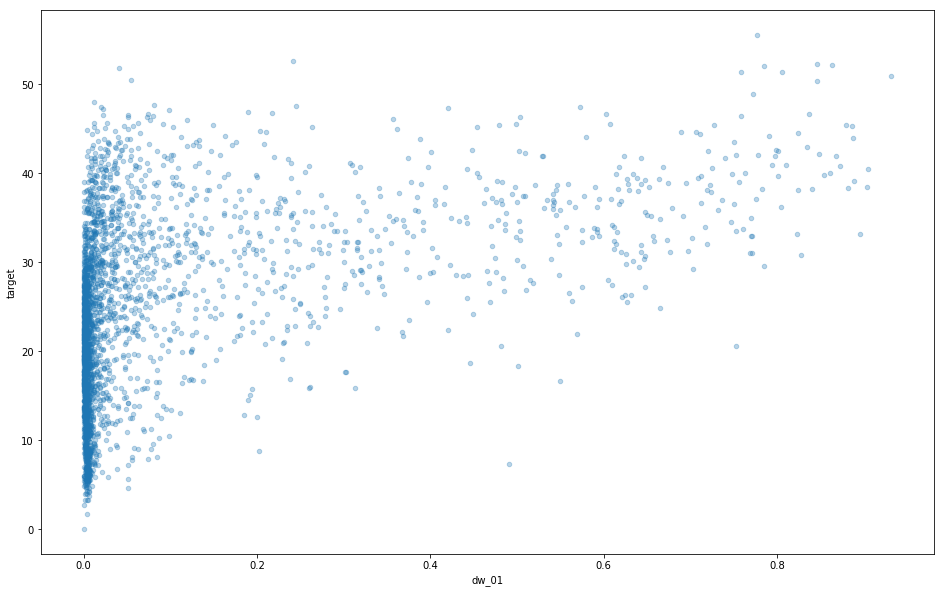

In [41]:
# dw_01: Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials
# Places where many of the buildings are 'traditional' tend to have more households 
# in the target category. 
df.plot(x='dw_01', y='target', kind='scatter', alpha=0.3)

Notice that for the dwelling type example above, the left hand side of the graph is chaotic. Fitting a straight line would tell part of the story, but to fully capture the trend we'd have to look at this data in conjunction with info on all the other dwelling types, and think about how trends might be different in rural vs urban areas. 

### Tip - Take a look at more of these variables and explore their relationships further. This will give you some extra insight that may come in handy for feature engineering. It's also an interesting exercise on it's own - this is data about South Africa, and South African people. ...

# Modelling
At this stage, most tutorials/notebooks would go into feature engineering. But I like to do a quick model FIRST, to see how tough the problem is and give us a baseline to compare to. So, in this section we'll try a simple linear model and then a more complicated Random Forest regressor, and set up a means to score our models locally (so that we don't have to keep submitting on Zindi).

In [12]:
# Define our input columns.
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
in_cols

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00',
       'car_01', 'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02',
       'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04',
       'pw_05', 'pw_06', 'pw_07', 'pw_08', 'lat', 'lon', 'NL'],
      dtype='object')

In [13]:
# Specify our target variable
ycol = 'target'

In [14]:
# Fit a basic linear regression model, keeping the last 1000 rows for scoring
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df[in_cols][:-1000], df[ycol][:-1000])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Evaluating Predictions

How do we evaluate our predictions? if we run `lm.score(df[in_cols][-1000:], df[ycol][-1000:])`, we'll get something called the 'R-Squared Score', which is a measure of how well our model explains the variation in the target variable. The closer to 1, the better. But this can be hard to visualize, so I like to plot predictions vs true values to get a better idea of how close our model is coming.

Neither of these tell us what our score on Zindi will look like. The metric used to evaluate submissions is RMSE - more info [here](https://www.statisticshowto.datasciencecentral.com/rmse/). 

Let's evaluate our first linear model:

In [15]:
lm.score(df[in_cols][-1000:], df[ycol][-1000:]) # R2 score

-8.703435981030182

In [16]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]))))

RMSE: 29.73053138118593


Yikes! That seems bad? What is going on...

In [45]:
# Plot predicted vs actual
plt.scatter(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]), alpha=0.3)
plt.plot(df[ycol][-1000:], df[ycol][-1000:]) # A straight line - we want to be close to this
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

ValueError: shapes (1000,59) and (58,) not aligned: 59 (dim 1) != 58 (dim 0)

So the model is getting most predictions close to the mark, but some are waaaay off (causing the terrible score) and lots are negative! Let's move on to a better model.

In [18]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rf = RandomForestRegressor(n_estimators=100) # My go-to quick model for regression tasks.
rf.fit(df[in_cols][:-1000], df[ycol][:-1000])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
rf.score(df[in_cols][-1000:], df[ycol][-1000:]) # Very good!

0.8164763733386365

In [21]:
print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], rf.predict(df[in_cols][-1000:]))))

RMSE: 4.088706065254134


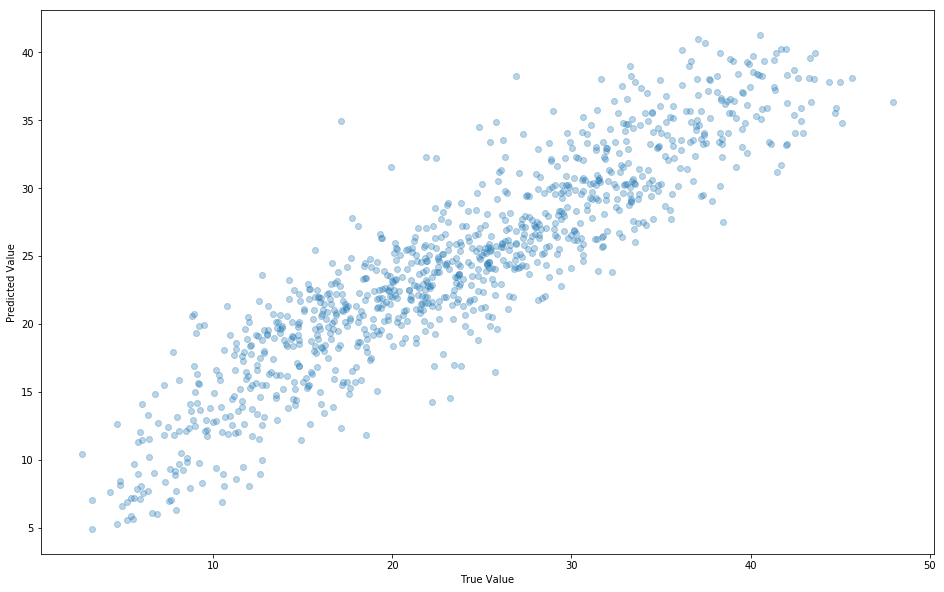

In [22]:
plt.scatter(df[ycol][-1000:], rf.predict(df[in_cols][-1000:]), alpha=0.3)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

Much better! We can see that the predicted values now line up fairly closely with the true values. 

A nice side-effect of this Random Forest model: We can see what features are most important to the model:

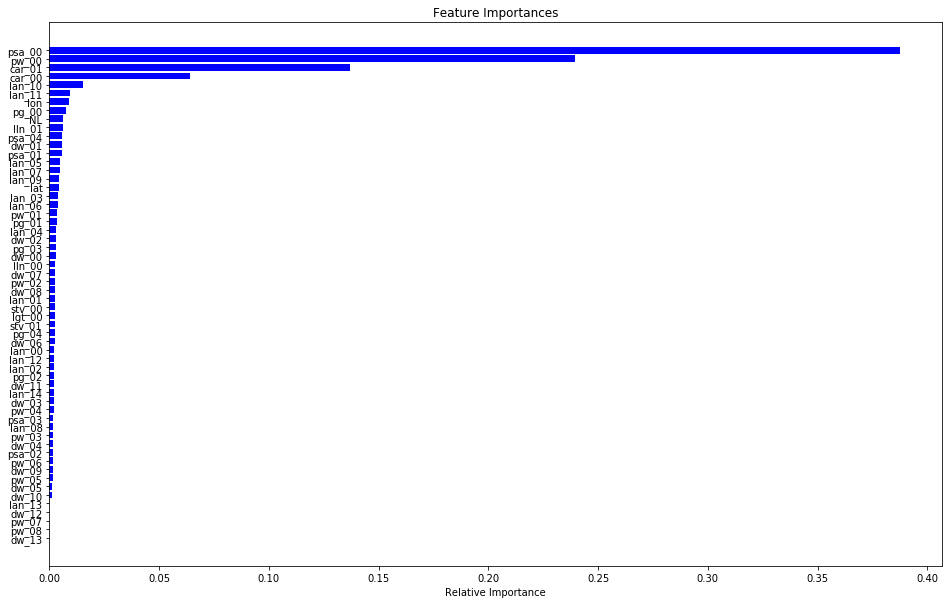

In [23]:
features = in_cols
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

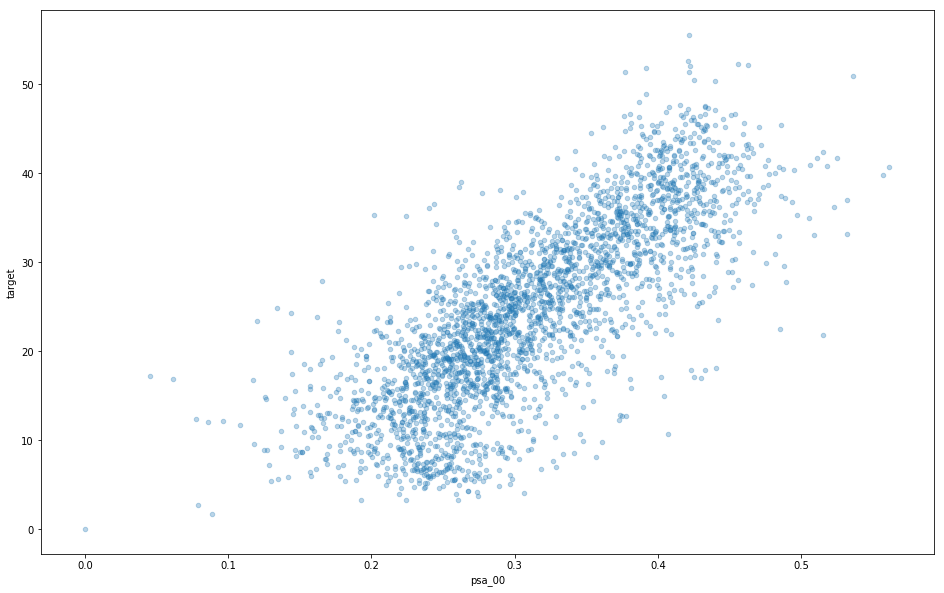

In [24]:
# It turns out school attendance is VERY informative!
df.plot(x='psa_00', y='target', kind='scatter', alpha=0.3)

### Better scoring with Cross-Validation

We could start tweaking model parameters and trying different models, using the code above to get the score. But this gives a score for just one split - we could pick a worse model that just happens to do well on the last 1000 rows. instead, we'll use something called k-fold cross validation to get a better estimate of how well one model does in relation to another.

In [25]:
from sklearn.model_selection import KFold

# Demonstrating splits
kf = KFold(n_splits=5, shuffle=False)
for train, test in kf.split(df):
  print(df.iloc[train].shape, df.iloc[test].shape)

(2257, 63) (565, 63)
(2257, 63) (565, 63)
(2258, 63) (564, 63)
(2258, 63) (564, 63)
(2258, 63) (564, 63)


In [26]:
# Using this to test a model on 5 different splits
kf = KFold(n_splits=5, shuffle=False)

scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

3.8153954685061744
3.505145823503643
4.6434131311101865
4.262917305928946
4.011405532821516
Average score in 5-fold CV: 4.0476554523740935


As you can see, the scores vary depending on the split. Taking the average of 5 runs gives a much better estimate of the total. You could go higher, but 5 should be enough to see major differences.

A question for you: Why did we set shuffle=False?

In [27]:
kf = KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

3.3609372691455004
3.6035110413023874
3.5506293518948144
3.4371517504348326
3.640702797079457
Average score in 5-fold CV: 3.518586441971398


The wards are bits of land in South Africa. If we do a random split, we will have wards in the test set with adjacent wards in the training set. Since nearby locations are often similar, the model is able to make good guesses simply by looking at the neighbouring wards and extrapolating. But for this model to be useful, we want it to generalise well, so that we could potentially make predictions for now without doing ANY surveys. 

This is reflected in the way Zindi split the data - certain provinces are not represented at all in the training set. By splitting sequentially, we take advantage of the way the training set is ordered (by ward code) to do our own 'geographical' splits where adjacent regions are grouped together. 

So, use `shuffle=False` to get a better idea of what your model will score on Zindi.

### Tip: Sometimes a quick test/train split is enough to get an idea about how well something is doing, but when you're tuning parameters and comparing models it's worth the extra effort to do things rigorously. Try creating a score_model() function to make this quick and effortless going forward.

# Feature Engineering and Model Tuning

Let's add a new feature and tune our model a little bit, to see if we can beat our current score (4.01).

In [28]:
# Average household size - might contain some useful information
df['Household_Size'] = df['total_individuals']/df['total_households']

In [29]:
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
in_cols # Check that the new feature is included

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'dw_12', 'dw_13', 'psa_00',
       'psa_01', 'psa_02', 'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00',
       'car_01', 'lln_00', 'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03',
       'lan_04', 'lan_05', 'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10',
       'lan_11', 'lan_12', 'lan_13', 'lan_14', 'pg_00', 'pg_01', 'pg_02',
       'pg_03', 'pg_04', 'lgt_00', 'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04',
       'pw_05', 'pw_06', 'pw_07', 'pw_08', 'lat', 'lon', 'NL',
       'Household_Size'],
      dtype='object')

In [30]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 3.994170328476641


A small improvement, but every little bit helps!

### Tip: Spend some time on feature engineering. Look at ways to combine columns, or redundant info (percentage WITH car = 100- percentage without car, so perhaps one could be scrapped?). Check out extra sources of info. Can you use the coorinates to classify wards as Urban vs Rural? How about using the ward code to find the wards in the shapefile, and getting geographical area or coastline? For the very advanced, even satellite imagery might yield some useful info...

Let's try to tune the max_depth parameter in case our model is overfitting.

In [31]:
for md in [3, 4, 5, 7, 9, 12, 15]:
  scores = []
  for train, test in kf.split(df):
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
    rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
    scores.append(rmse)
  print("Average score in 5-fold CV:", np.mean(scores), "for max depth:", md)

Average score in 5-fold CV: 4.786288589223463 for max depth: 3
Average score in 5-fold CV: 4.503163066902348 for max depth: 4
Average score in 5-fold CV: 4.297723325300029 for max depth: 5
Average score in 5-fold CV: 4.12190530997769 for max depth: 7
Average score in 5-fold CV: 4.030847087033656 for max depth: 9
Average score in 5-fold CV: 4.002424390736214 for max depth: 12
Average score in 5-fold CV: 3.9998139697198347 for max depth: 15


Deeper models did better. 
### Tip: Try plotting score vs depth, and see where the model stops improving. You can also tune many other parameters

### Tip: Experiment with different models! There are many to choose from, and my favourite old Random Forest is feeling a little overwhelmed by the cool kids: XGBoost, LGBMs, NODE, 🐱boost...

# Making a submission

OK, so we have a model we're happy with. Now to make our submission. First, let's look at the submission format

In [32]:
pd.read_csv('SampleSubmission.csv').head()

,ward,target
0,21001001: Ward 1,21.87
1,21001002: Ward 2,65.94
2,21001003: Ward 3,83.65
3,21001004: Ward 4,NaN
4,21001005: Ward 5,NaN


For each ward, we need to predict the target. Let's do it

In [33]:
# Load the test data
test = pd.read_csv('Test.csv')
# Add any extra features just as we did for train
test['Household_Size'] = test['total_individuals']/test['total_households']

In [34]:
# Fit a model on the whole training set, using our best parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=15)
rf.fit(df[in_cols], df[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [35]:
# Make predictions
test['target'] = rf.predict(test[in_cols])
test.head()

,ward,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,...,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL,Household_Size,target
0,21001001: Ward 1,2504.95194,8745.15151,0.947257,0.000873,0.002021,0.000000,0.000000,0.030116,0.000452,...,0.0,0.006649,0.0,0.0,ZA2101001,-32.637758,23.848688,0.000000,3.491145,19.333935
1,21001002: Ward 2,2080.27718,7258.11764,0.844993,0.000481,0.043629,0.004714,0.012323,0.012300,0.022132,...,0.0,0.002916,0.0,0.0,ZA2101002,-31.990536,24.555818,0.000000,3.489015,14.439229
2,21001003: Ward 3,1106.62639,5919.13170,0.651380,0.007937,0.007113,0.000000,0.001977,0.259711,0.006505,...,0.0,0.000000,0.0,0.0,ZA2101003,-32.283595,24.563940,8.269556,5.348808,22.231800
3,21001004: Ward 4,2175.56096,10280.57452,0.410837,0.002468,0.011511,0.000485,0.000000,0.449604,0.009256,...,0.0,0.001379,0.0,0.0,ZA2101004,-32.261612,24.542202,8.626625,4.725482,15.683928
4,21001005: Ward 5,1270.83883,6018.34202,0.942851,0.002638,0.000821,0.000000,0.000891,0.000787,0.000830,...,0.0,0.001660,0.0,0.0,ZA2101005,-32.251571,24.558537,8.601754,4.735724,22.021119


In [36]:
# Save and submit!
test[['ward', 'target']].to_csv('starter_nb_submission.csv', index=False)

And that's it! Upload your submission file to Zindi and see what you get :) If all works out well, you should get a score very similar to the one we got in our tests. That said, the test set includes Cape Town, so if your score is slightly lower than expected feel free to blame it on the DA ;)